### Survival Analysis  in Scikit Learn and XGBoost & Link XGBoost result to probability of survival by SkSuviv
https://github.com/sebp/scikit-survival

/Users/mpeng/Applications/anaconda3/envs/dev37/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Text(0.5, 0, 'time $t$')

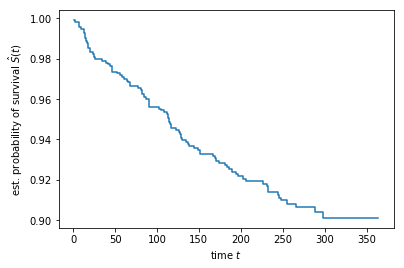

In [1]:
# y must be a structured array with the first field being a binary class event indicator 
# and the second field the time of the event/censoring

%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import scale
from sksurv.datasets import load_aids
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from numba import jit
import shap
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored


# load and inspect the data
data_x, data_y = load_aids()
data_x = data_x[list(np.setdiff1d(data_x.columns.values, ["hemophil"]))]
data_x_raw = data_x.copy()

if False:
    # change y value a bit and see how it goes
    data_y = np.array([list(x) for x in data_y])
    data_y = pd.DataFrame(data_y)
    data_y.columns = ['censor','time']
    data_y['censor'] = True
    data_y = np.core.records.fromarrays(data_y.values.transpose(), 
                                             names='censor, time',
                                             formats = '?,f8')

#time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
time, survival_prob = kaplan_meier_estimator(pd.DataFrame(data_y)['censor'].astype(np.bool), pd.DataFrame(data_y)['time'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [2]:
display(data_x.head(), data_y)

,age,cd4,ivdrug,karnof,priorzdv,raceth,sex,strat2,tx,txgrp
0,34.0,169.0,1,100,39.0,1,1,1,0,1
1,34.0,149.5,1,90,15.0,2,2,1,0,1
2,20.0,23.5,1,100,9.0,1,1,0,1,2
3,48.0,46.0,1,90,53.0,1,1,1,0,1
4,46.0,10.0,3,90,12.0,1,1,0,1,2


array([(False, 189.), (False, 287.), (False, 242.), ..., (False, 272.),
       (False, 192.), (False, 132.)],
      dtype=[('censor', '?'), ('time', '<f8')])

In [3]:
# Since XGBoost only allow one column for y, the censoring information is coded as negative values:
data_y_xgb = np.array([x[1] if x[0] else -x[1] for x in data_y])
data_y_xgb[10:15]

array([-334., -285., -265.,  206., -305.])

In [ ]:
# Since sksurv output log hazard ratios (here relative to 0 on predictors) 
# we must use 'output_margin=True' for comparability.
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=42)
# Train Test index split
train_idx, test_idx = train_test_split(np.arange(len(data_x)), test_size=0.33, random_state=42)

if data_x.__class__ != np.ndarray:
    data_x = data_x.astype(np.float).values # convert data_x into matrix
    #data_x = scale(data_x, axis=0, with_mean=True, with_std=True, copy=True ) # scale X-matrix

estimator = CoxPHSurvivalAnalysis(alpha=50, n_iter=10000000).fit(data_x[train_idx], data_y[train_idx])
# Correct estimator's bias issue
prediction_sksurv_train = estimator.predict(data_x[train_idx])
estimator2 = CoxPHSurvivalAnalysis(alpha=0).fit(prediction_sksurv_train.reshape(-1,1), data_y[train_idx])
prediction_sksurv_train = estimator2.predict(prediction_sksurv_train.reshape(-1,1))
# XGBoost gblinear model
gbm1 = xgb.XGBRegressor(objective='survival:cox',
                       booster='gblinear', base_score=1,
                       reg_alpha=0.01, reg_lambda=0.01,
                       n_estimators=10000,
                       n_jobs=-1,
                       ).fit(data_x[train_idx], data_y_xgb[train_idx])
 #XGBoost gbtree model
params = {"eta": 0.001, "max_depth": 2, "objective": "survival:cox", "subsample": 0.85,
          "base_score": 1, "alpha":0.01, "lambda":0.001, "min_child_weight":2,
         "booster":'gbtree'}

dtrain = xgb.DMatrix(data_x[train_idx], label=data_y_xgb[train_idx])
dtest = xgb.DMatrix(data_x[test_idx], label=data_y_xgb[test_idx])
gbm2 = xgb.train(params, dtrain, num_boost_round=10000, 
                 evals = [(dtrain, "train"), (dtest, "test")], 
                 verbose_eval=True, early_stopping_rounds=100,
                 callbacks=[xgb.callback.print_evaluation(period=10, show_stdv=True)])

# Predictions
# Cox Regerssion module there can create bias that in the regularization, so it needs second round applying
# same Cox Regression to fix it
predictions_xgb1_train = gbm1.predict(data_x[train_idx], output_margin=True)
predictions_xgb2_train = gbm2.predict(dtrain, output_margin=True)
d = pd.DataFrame({'xgb1': predictions_xgb1_train,
                  'sksurv': prediction_sksurv_train,
                  "xgb2": predictions_xgb2_train})
# check if predicts by xgboost can be used in survival function
prediction_mix_train = CoxPHSurvivalAnalysis(alpha=0).fit(predictions_xgb2_train.reshape(-1,1), 
                                            data_y[train_idx]).predict(predictions_xgb2_train.reshape(-1,1))
d['xgb_plus_sksurv'] = prediction_mix_train

### Random search of hyper-parameters in XGBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer

def coxval(y_true, y_pred):
    res = concordance_index_censored(y_true >0, np.abs(y_true), y_pred)
    # the higher the better one
    return res[0]

coxval_new = make_scorer(coxval)

params_sarch = {
        'min_child_weight': [2, 10],
        'gamma': [0],
        "reg_alpha": [0.1, 1],
        "reg_lambda":[0.1, 1],
        'subsample': [0.8],
        'max_depth': [2]
        }
    
my_fit_params = {   
    "early_stopping_rounds":20,
    "eval_set" : [[data_x[test_idx], data_y_xgb[test_idx]]],
    "verbose": 0
}

# random search's parameter:
# specify the
clf = xgb.XGBRegressor(learning_rate=0.1, objective='survival:cox', base_score=1,
                       n_estimators=1000, silent=True)    
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
"""
random_search = RandomizedSearchCV(clf, param_distributions=params_sarch,
                                   n_iter=500, scoring=coxval_new,
                                   fit_params = my_fit_params,
                                   n_jobs=4, cv = 8,
                                   #cv=skf.split(data_x[train_idx], data_y_xgb[train_idx]), 
                                   verbose=3, random_state=1001)
"""
random_search = GridSearchCV(clf, param_grid=params_sarch, scoring=coxval_new,
                                   fit_params = my_fit_params,
                                   n_jobs=4, cv = 8, verbose=2)
res = random_search.fit(data_x[train_idx], data_y_xgb[train_idx])

In [6]:
# Random Grid Search result
res.best_params_, res.best_score_

({'gamma': 0,
  'max_depth': 2,
  'min_child_weight': 10,
  'reg_alpha': 0.1,
  'reg_lambda': 0.1,
  'subsample': 0.8},
 0.7488054366301636)

Train: Cox Survival Regression has Concordance index 0.769
Train: XGboost GBLinear has Concordance index 0.764
Train: XGboost Boosting Tree Regression has Concordance index 0.85220494
Train: XGboost Boosting Tree + Survival Regression has Concordance index 0.85220494


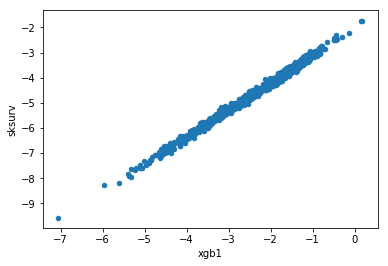

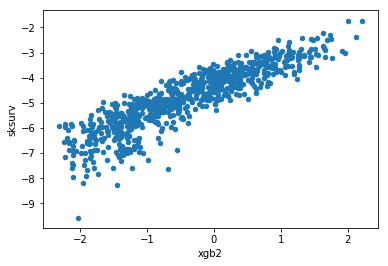

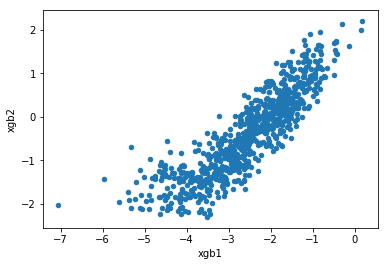

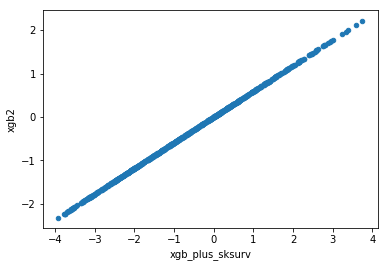

In [7]:
d.plot.scatter('xgb1','sksurv')
d.plot.scatter('xgb2','sksurv')
d.plot.scatter('xgb1','xgb2')
d.plot.scatter('xgb_plus_sksurv','xgb2')

result = concordance_index_censored(data_y["censor"][train_idx], data_y["time"][train_idx], prediction_sksurv_train)
print("Train: Cox Survival Regression has Concordance index {:.3}".format(result[0]))
result = concordance_index_censored(data_y["censor"][train_idx], data_y["time"][train_idx], predictions_xgb1_train)
print("Train: XGboost GBLinear has Concordance index {:.3}".format(result[0]))
result = concordance_index_censored(data_y["censor"][train_idx], data_y["time"][train_idx], predictions_xgb2_train)
print("Train: XGboost Boosting Tree Regression has Concordance index {:.8}".format(result[0]))
result = concordance_index_censored(data_y["censor"][train_idx], data_y["time"][train_idx], prediction_mix_train)
print("Train: XGboost Boosting Tree + Survival Regression has Concordance index {:.8}".format(result[0]))

## Show the result on 33% of test data

Test: Cox Survival Regression has Concordance index 0.793
Test: XGboost GBLinear has Concordance index 0.793
Test: XGboost Boosting Tree Regression has Concordance index 0.78004222
Test: XGboost Boosting Tree + Survival Regression has Concordance index 0.78004222
Test: Ensemble XGBoost+Survival has Concordance index 0.7911


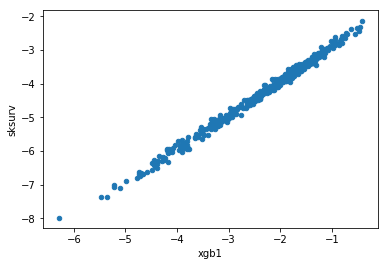

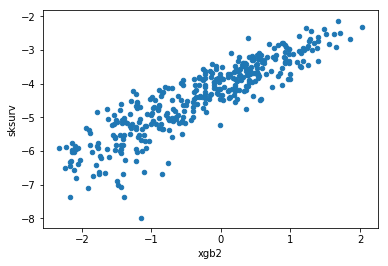

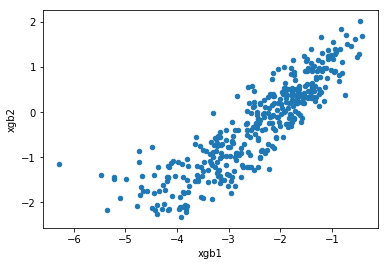

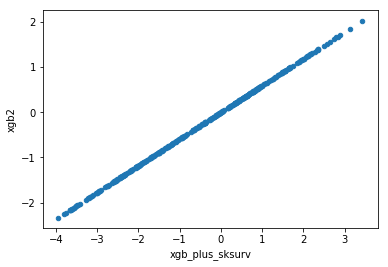

In [8]:
prediction_sksurv_test = estimator.predict(data_x[test_idx])
predictions_xgb1_test = gbm1.predict(data_x[test_idx], output_margin=True)
predictions_xgb2_test = gbm2.predict(dtest, output_margin=True)
d = pd.DataFrame({'xgb1': predictions_xgb1_test,
                  'sksurv': prediction_sksurv_test,
                  "xgb2": predictions_xgb2_test})
# check if predicts by xgboost can be used in survival function
prediction_mix_test = CoxPHSurvivalAnalysis(alpha=0).fit(predictions_xgb2_train.reshape(-1,1), 
                                        data_y[train_idx]).predict(predictions_xgb2_test.reshape(-1,1))
d['xgb_plus_sksurv'] = prediction_mix_test

d.plot.scatter('xgb1','sksurv')
d.plot.scatter('xgb2','sksurv')
d.plot.scatter('xgb1','xgb2')
d.plot.scatter('xgb_plus_sksurv','xgb2')

result = concordance_index_censored(data_y["censor"][test_idx], data_y["time"][test_idx], prediction_sksurv_test)
print("Test: Cox Survival Regression has Concordance index {:.3}".format(result[0]))
result = concordance_index_censored(data_y["censor"][test_idx], data_y["time"][test_idx], predictions_xgb1_test)
print("Test: XGboost GBLinear has Concordance index {:.3}".format(result[0]))
result = concordance_index_censored(data_y["censor"][test_idx], data_y["time"][test_idx], predictions_xgb2_test)
print("Test: XGboost Boosting Tree Regression has Concordance index {:.8}".format(result[0]))
result = concordance_index_censored(data_y["censor"][test_idx], data_y["time"][test_idx], prediction_mix_test)
print("Test: XGboost Boosting Tree + Survival Regression has Concordance index {:.8}".format(result[0]))
result = concordance_index_censored(data_y["censor"][test_idx], data_y["time"][test_idx], 0.2*predictions_xgb2_test+0.8*prediction_sksurv_test)
print("Test: Ensemble XGBoost+Survival has Concordance index {:.4}".format(result[0]))

### Sanity Check: Check if the Cox survival probabilities make sense, one may use K-M estimation of probability of survival to match average survival probability of Cox survival probabilities and check if they align. This is to avoid the bias creation in the Cox survival model through regularization

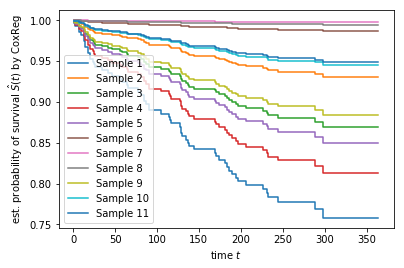

In [9]:
pred_surv = estimator2.predict_survival_function(estimator.predict(data_x[test_idx]).reshape(-1,1))
for i, c in enumerate(pred_surv):
    if i <= 10: # just print out the survival prob curve for first 6 samples
        plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
    else: break
plt.ylabel("est. probability of survival $\hat{S}(t)$ by CoxReg")
plt.xlabel("time $t$")
plt.legend(loc="best")

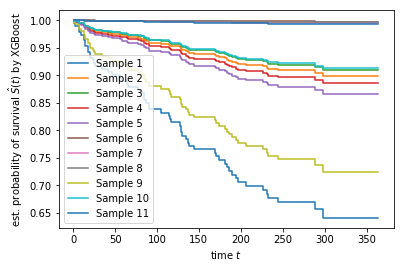

In [10]:
pred_surv = CoxPHSurvivalAnalysis(alpha=0).fit(predictions_xgb2_train.reshape(-1,1), data_y[train_idx]).predict_survival_function(
                predictions_xgb2_test.reshape(-1,1))
for i, c in enumerate(pred_surv):
    if i <= 10: # just print out the survival prob curve for first 6 samples
        plt.step(c.x, c.y, where="post", label="Sample %d" % (i + 1))
    else: break
plt.ylabel("est. probability of survival $\hat{S}(t)$ by XGBoost")
plt.xlabel("time $t$")
plt.legend(loc="best")

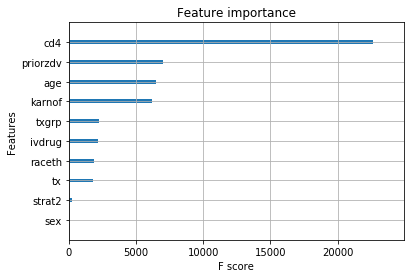

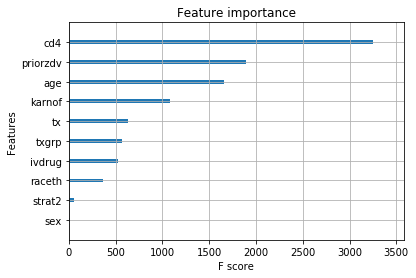

In [11]:
# Compute feature importance matrix
gbm2_copy = gbm2.copy()
gbm2.feature_names = list(data_x_raw.columns.values)
xgb.plot_importance(booster=gbm2, importance_type="total_gain", show_values=False)
xgb.plot_importance(booster=gbm2, importance_type="weight", show_values=False)

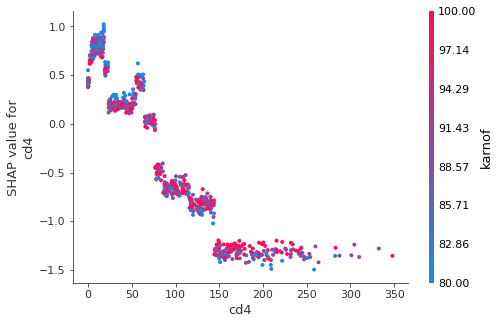

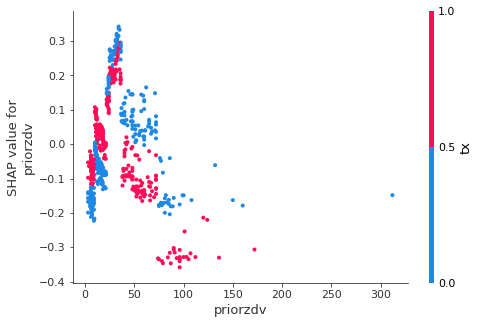

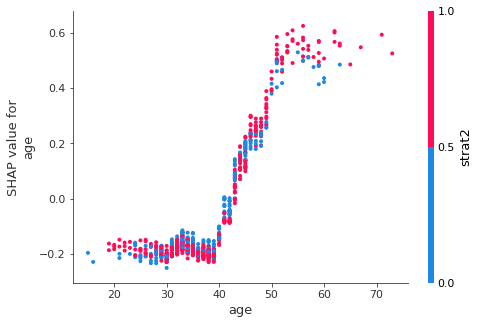

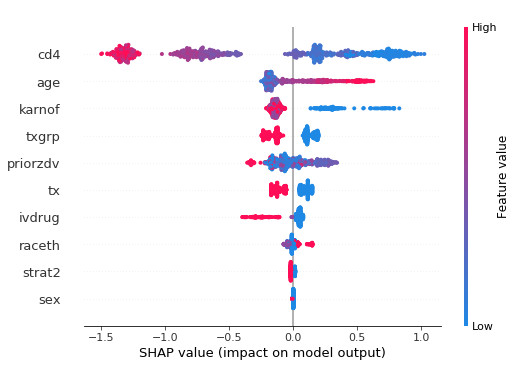

In [12]:
shap_values = shap.TreeExplainer(gbm2_copy).shap_values(data_x[train_idx])
shap.dependence_plot("cd4", shap_values, data_x_raw.iloc[train_idx].astype(np.float))
shap.dependence_plot("priorzdv", shap_values, data_x_raw.iloc[train_idx].astype(np.float))
shap.dependence_plot("age", shap_values, data_x_raw.iloc[train_idx].astype(np.float))
shap.summary_plot(shap_values, data_x[train_idx], feature_names=gbm2.feature_names)